Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import  integrate
import os
from astropy.io import fits
from tqdm import tqdm,trange
from scipy.optimize import curve_fit
from matplotlib import gridspec

In [2]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

Load data

In [3]:
percentiles=np.load('../../spender_fixed/saved_input/percentiles_100000.npy')
wave=np.load('../../spender_fixed/saved_input/waves.npy')
index_sh=np.load('../saved_models/index_sh_1e5.npy')
means_sh=np.load('../saved_models/means.npy') #predictions

ms_real=np.load('/scratch/pin/sfh/seds_large/sfh_local.npy') #only first 1000 items before shuffling
seds_real=np.load('/scratch/pin/sfh/seds_large/seds_local.npy') #only first 1000 items before shuffling

index_in_short=np.where(index_sh[90000:]<1000)[0] #what we were able to save in local

#index_sh[90000:] are the elements for which we have the mean predicted percentiles
#and we only have seds and ms for first 1000 elements before shuffling


percentiles_sh=percentiles[index_sh[90000:][index_in_short]] #real
seds_real_sh=seds_real[index_sh[90000:][index_in_short]]
ms_real_sh=ms_real[index_sh[90000:][index_in_short]]
means_sh=means_sh[index_in_short]

print(np.shape(percentiles_sh),np.shape(seds_real_sh),np.shape(ms_real_sh))

(95, 9) (95, 4300) (95, 1401)


Quick visualization check

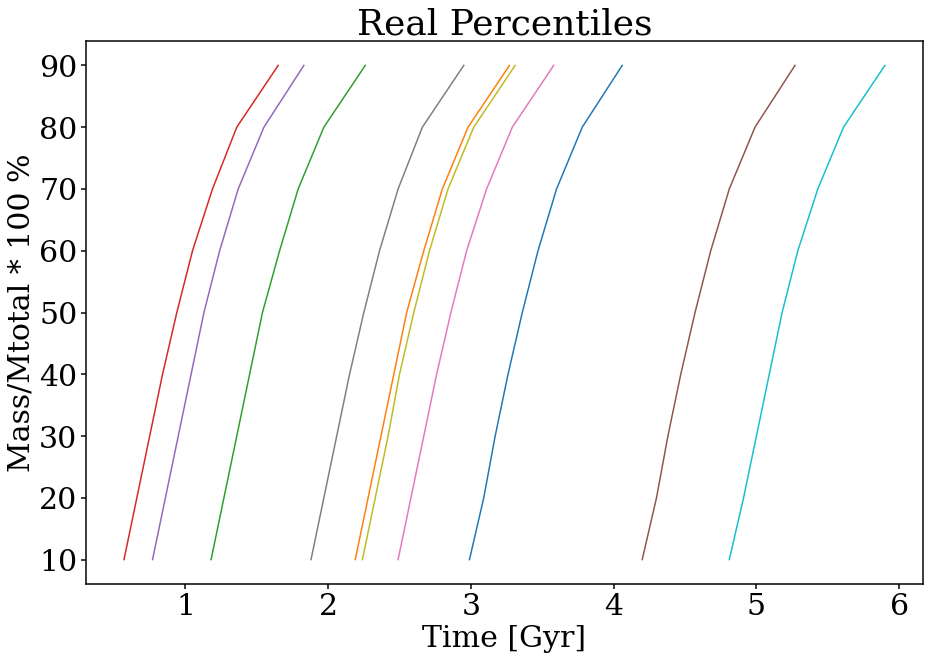

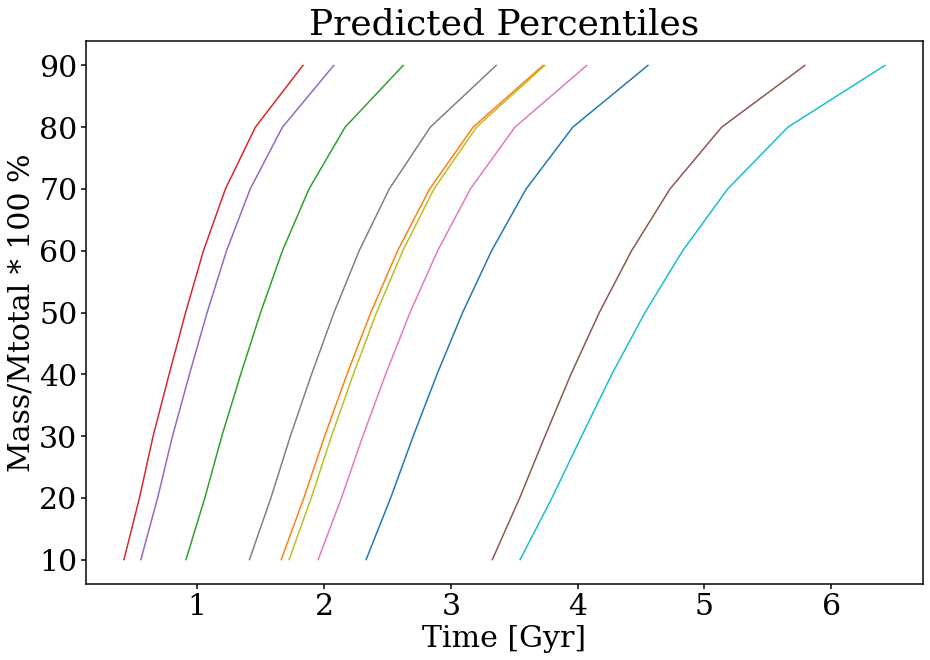

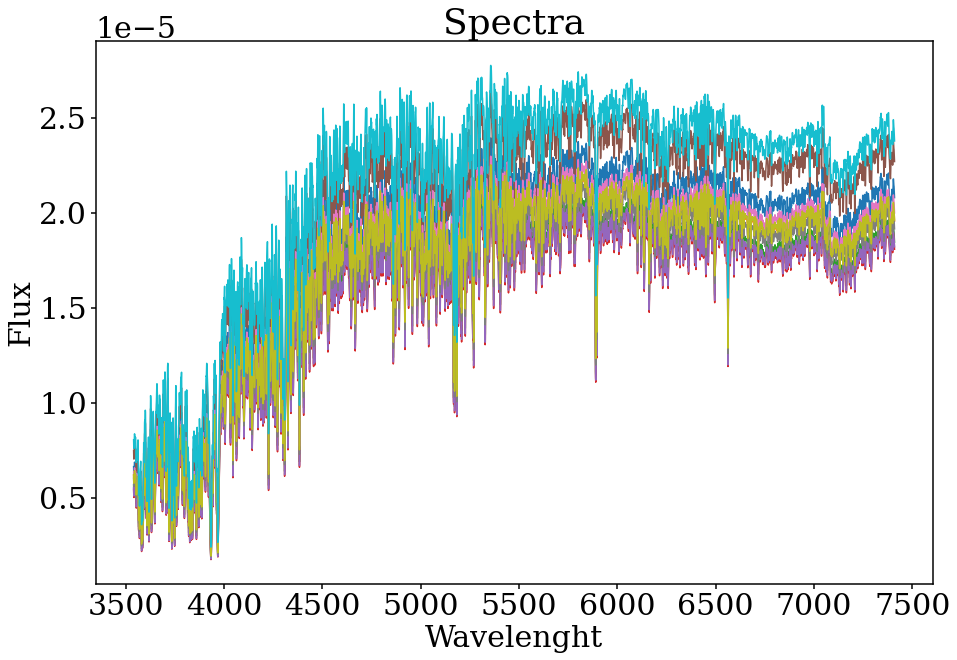

In [4]:
for i in np.arange(10): 
    plt.plot(percentiles_sh[i,:],np.arange(10,100,10))
plt.title('Real Percentiles') 
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')
plt.show()

for i in np.arange(10): 
    plt.plot(means_sh[i,:],np.arange(10,100,10))
plt.title('Predicted Percentiles') 
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')
plt.show()

for i in np.arange(10): #really 100.000 examples
    plt.plot(wave,seds_real_sh[i,:])
plt.title('Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.show()

Let's get from the real percentiles the sfh

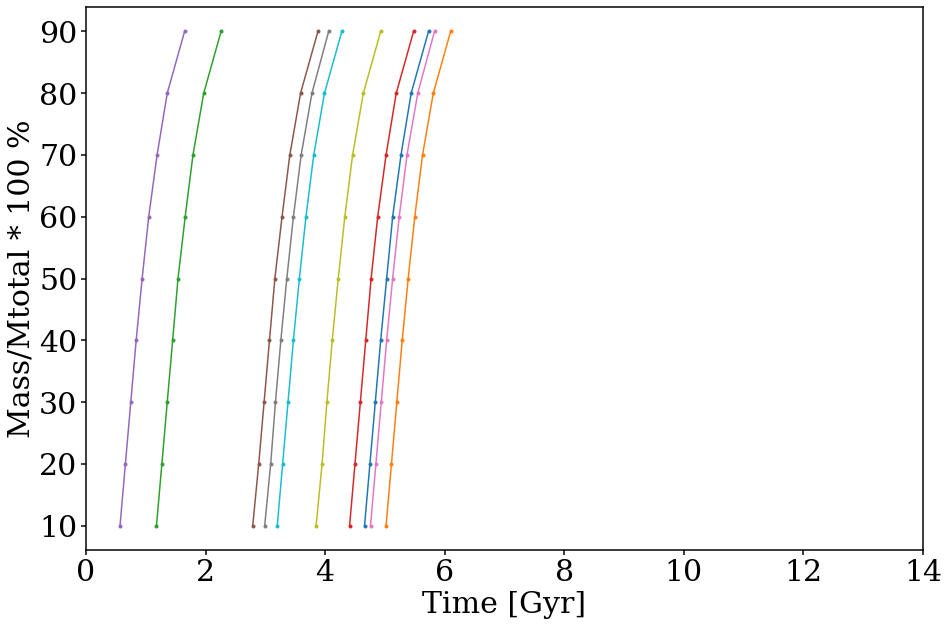

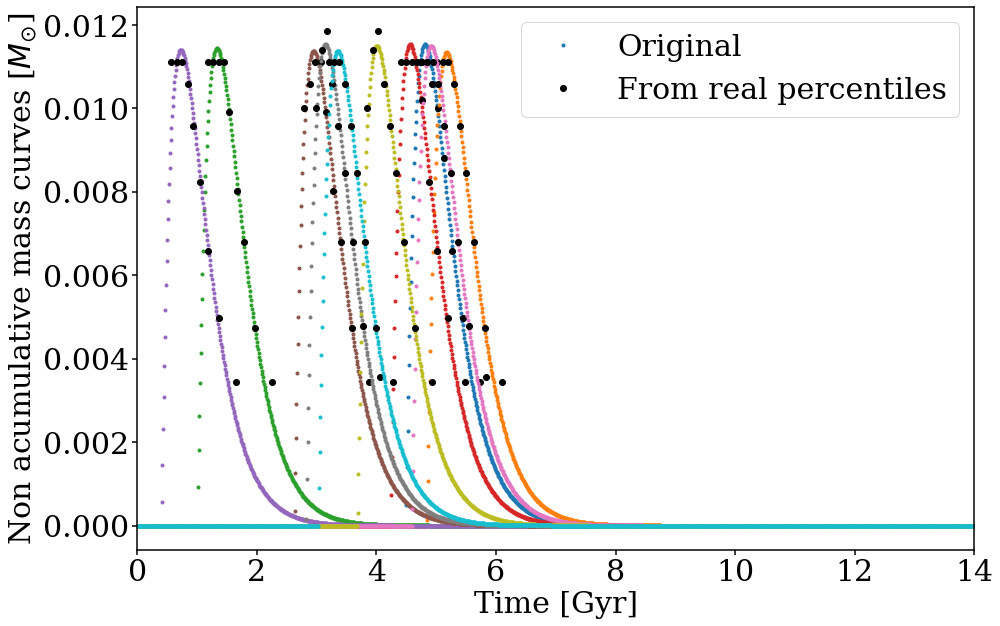

  0%|                                                                                                                                                    | 0/95 [00:00<?, ?it/s]/tmp/ipykernel_5552/982757475.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  A=mgal/i[0]
/tmp/ipykernel_5552/982757475.py:53: RuntimeWarning: invalid value encountered in multiply
  return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti)*step #units are Msun
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:14<00:00,  6.51it/s]


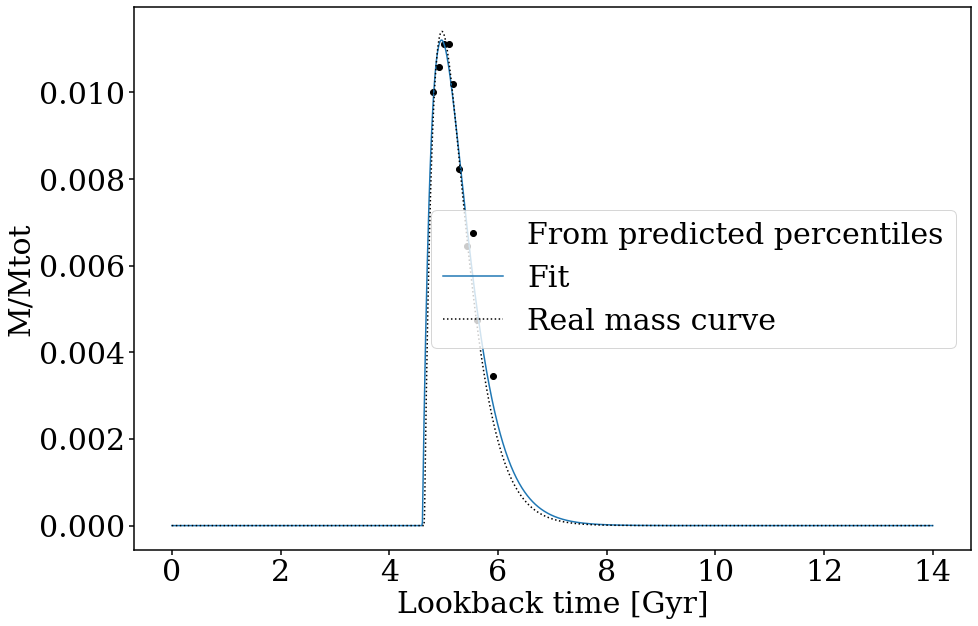

0.35193076729715334 4.6091426618343245 1.072456252957204


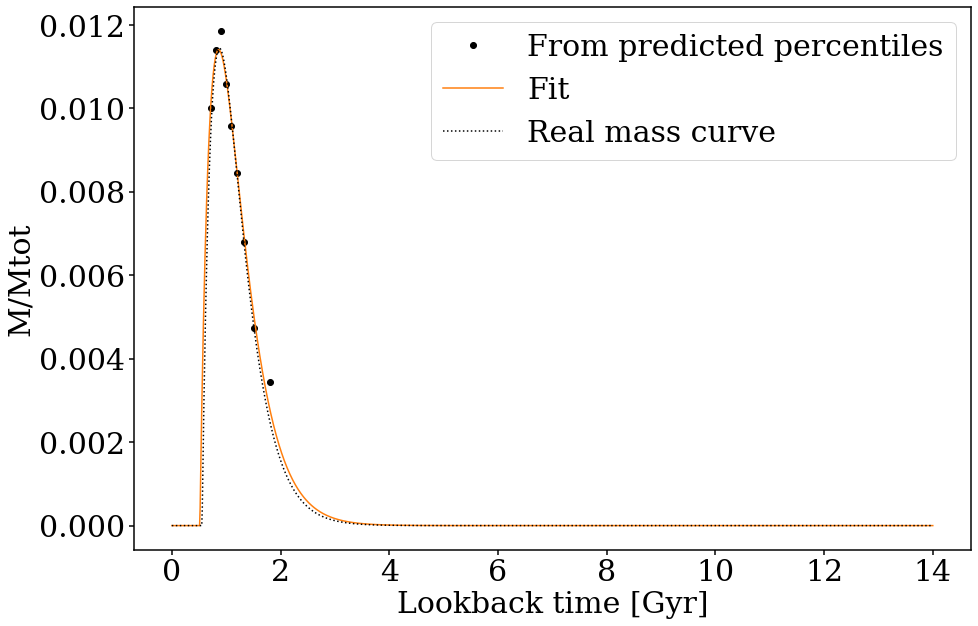

0.3456276571514581 0.5153255022750085 1.0718912198051207


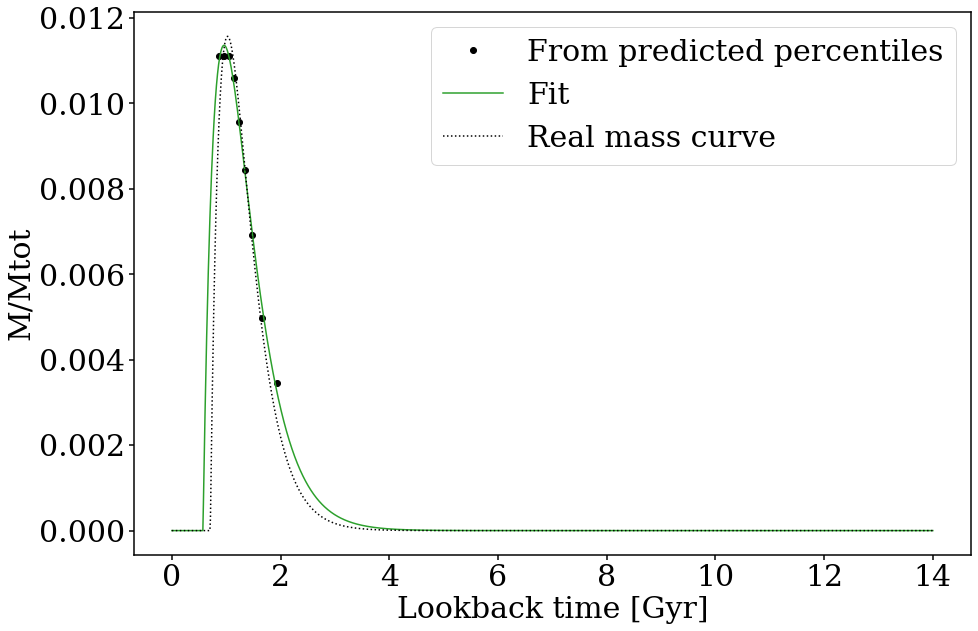

0.3878849519297472 0.5721402836101325 1.1977709221076336


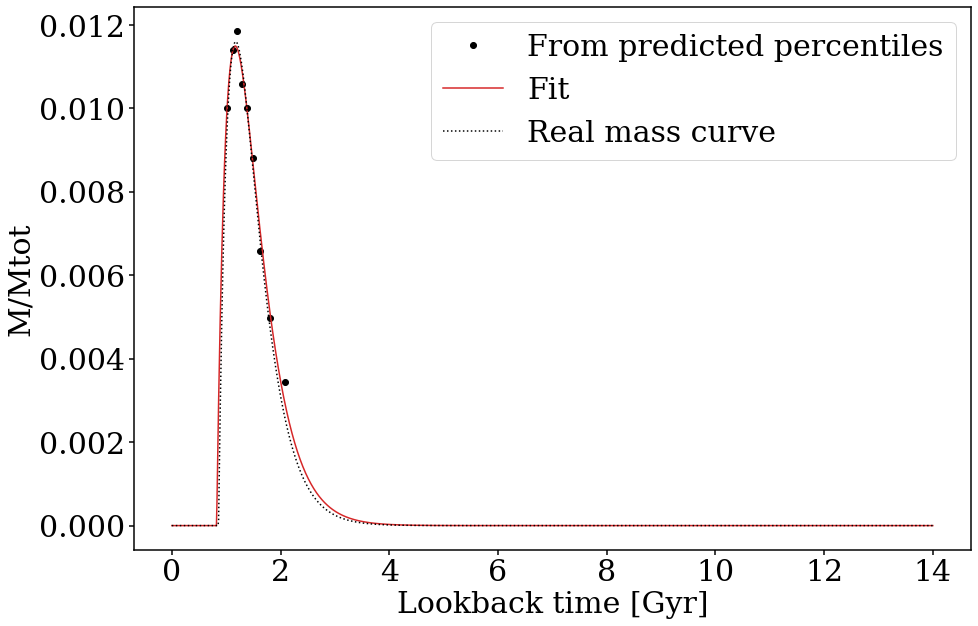

0.3427684952840297 0.8236690917312212 1.0712819100338145


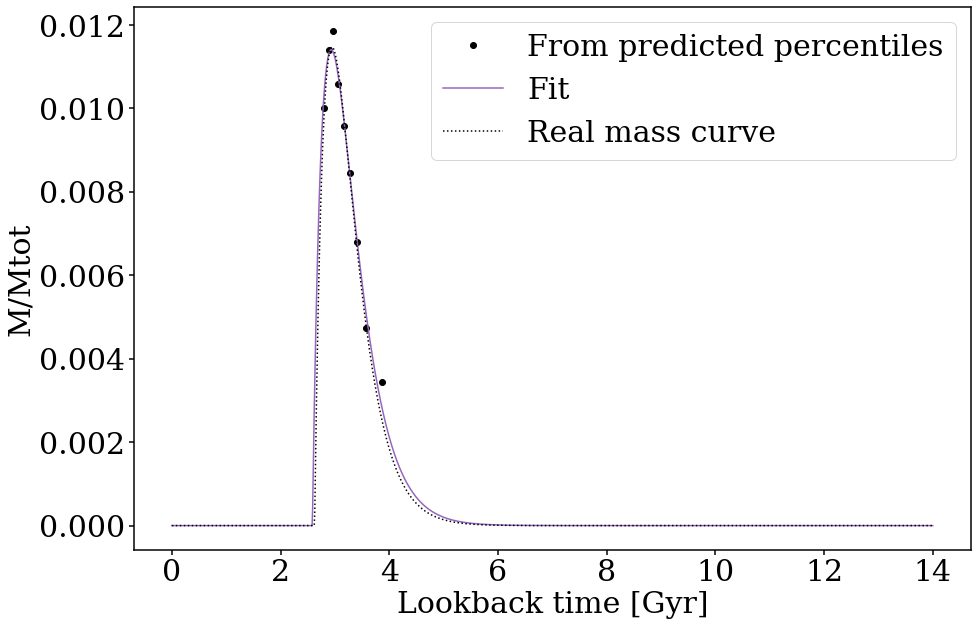

0.34562785120812184 2.5853252367937554 1.0718916835563708


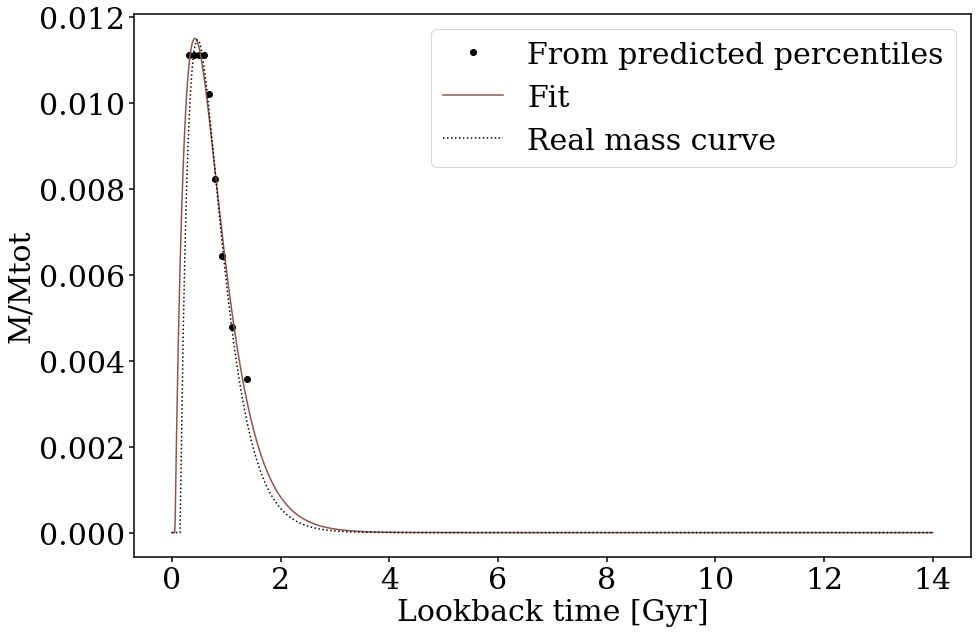

0.36688725859876564 0.05715077601018739 1.1476639284617407


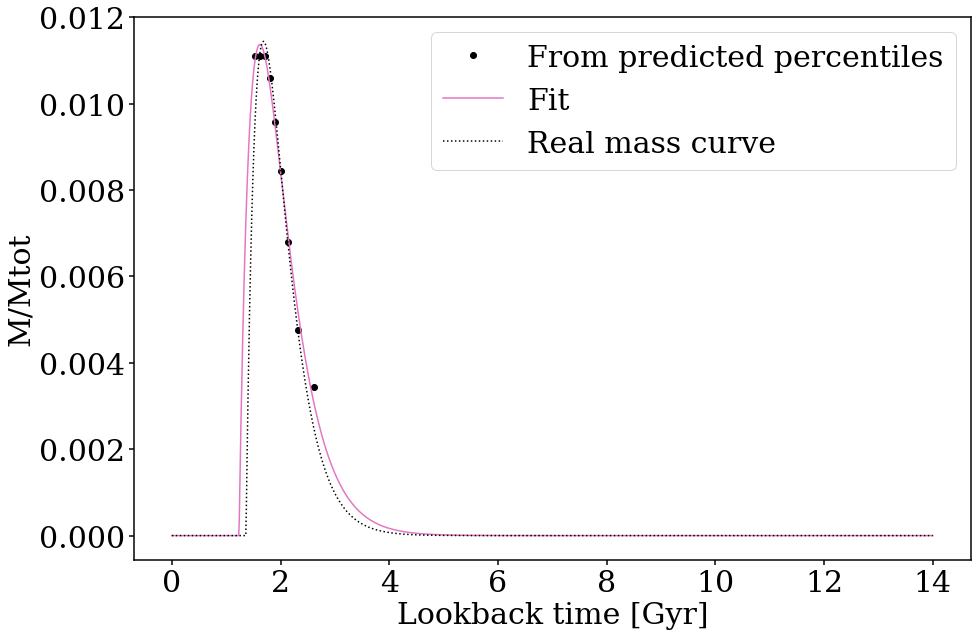

0.38414056836528443 1.235678180514519 1.1869919969501206


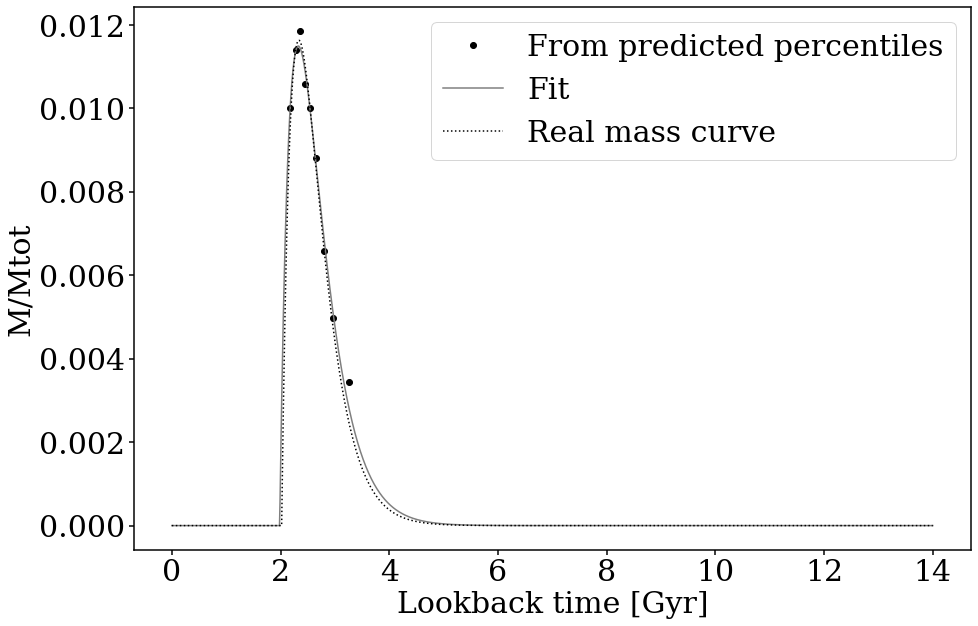

0.34276832379109334 1.9836693177418887 1.0712814980740955


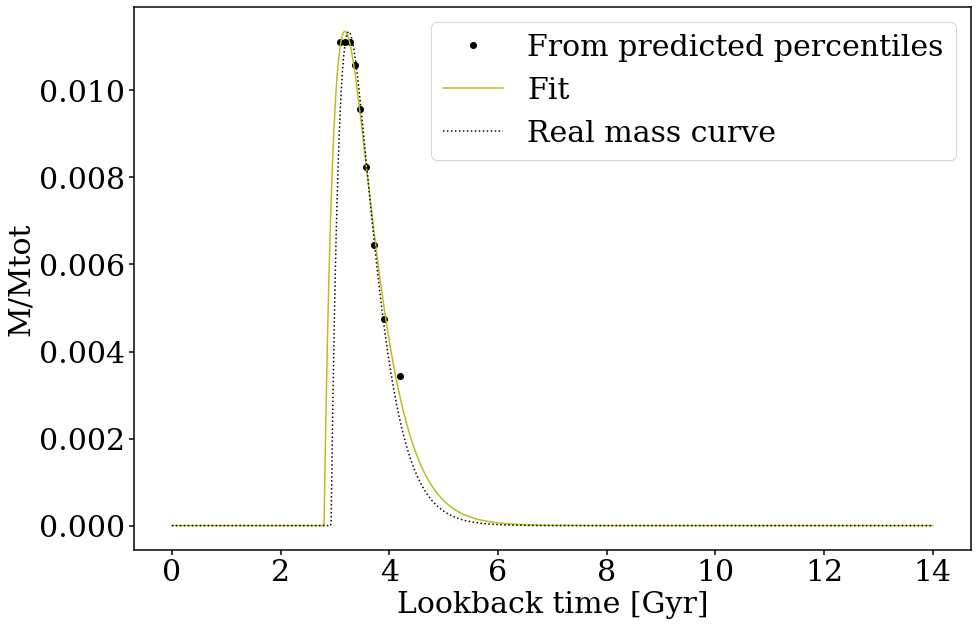

0.38419426266446766 2.8000682315193344 1.1859936446976926


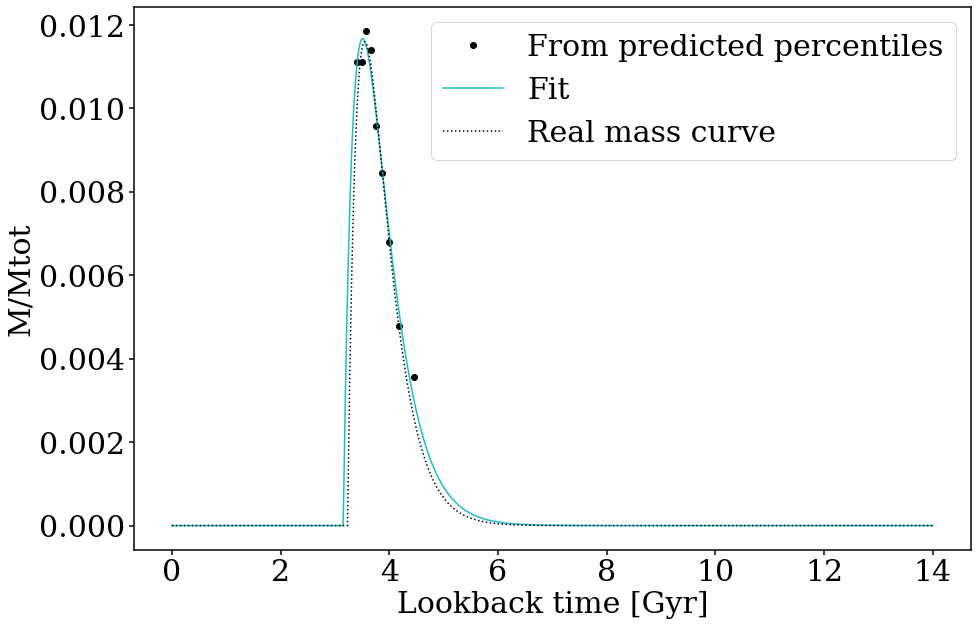

0.3563311430456236 3.153054322972633 1.130468261821312


In [5]:
index_list=np.random.randint(0,95,10)


#show percentiles
for k,i in enumerate(index_list):
    per=percentiles_sh[i,:]
    plt.plot(per[:],np.arange(10,100,10),'.-',color='C'+str(k))
plt.xlim(0,14)
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')
plt.show()
    
#show non accumulative mass curve (unit Msun)
for k,i in enumerate(index_list):
    per=percentiles_sh[i,:]
    ms=np.gradient(np.arange(0.1,1,0.1),per)
    if k==0:
        plt.plot(np.arange(0,14.01,0.01),ms_real_sh[i,:],'.',color='C'+str(k),label='Original')
        plt.plot(per,ms*0.01,'o',color='k',label='From real percentiles')
    else:
        plt.plot(np.arange(0,14.01,0.01),ms_real_sh[i,:],'.',color='C'+str(k))
        plt.plot(per,ms*0.01,'o',color='k')
        
plt.xlim(0,14)
plt.legend(loc='upper right')
plt.xlabel('Time [Gyr]')
plt.ylabel('Non acumulative mass curves [$M_{\\odot}$]')
plt.show()

#save non accumulative mass curves obtained from real percentiles (with fitting)

ms_from_percentiles=[]
for i in trange(95):
    per=percentiles_sh[i,:]
    ms=np.gradient(np.arange(0.1,1,0.1),per)*0.01 #unit Msun
    ms_from_percentiles.append(ms)
ms_from_percentiles=np.array(ms_from_percentiles)
    
#Now fit these into a exponentially delayed SFH

def escalon(t,ti):
    return t>ti

def sfr_linear_exp(t,tau,ti,mgal):
    i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
    A=mgal/i[0]
    return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) #units are Msun/Gyr

def m_linear_exp(t,tau,ti,mgal):
    i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
    A=mgal/i[0]
    step=0.01
    return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti)*step #units are Msun

"""for i in range(10):
    print(np.sum(ms_from_percentiles[i]*0.01))"""

params_list=[]
for i in trange(95):
    params, cov = curve_fit(m_linear_exp,percentiles_sh[i,:],ms_from_percentiles[i,:])
    params_list.append(params)

t=np.arange(0,14.01,0.01)


for k,i in enumerate(np.random.randint(0,95,10)):
    plt.plot(percentiles_sh[i,:],ms_from_percentiles[i,:],'o',color='k',label='From predicted percentiles')
    fit=m_linear_exp(t,params_list[i][0],params_list[i][1],params_list[i][2])
    plt.plot(t,fit,c='C'+str(k),label='Fit')
    plt.plot(t,ms_real_sh[i,:],'k:',label='Real mass curve')
    plt.legend()
    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel('M/Mtot')
    plt.show()
    print(params_list[i][0],params_list[i][1],params_list[i][2])
    
#seem to work

In [ ]:
#what about interpolate  ###imposible without percentil 0%
"""t=np.arange(0,14.01,0.01)


ms_full_from_percentiles=[]
for i in trange(108):  
    x=np.interp(t,percentiles_sh[i,:],ms_from_percentiles[i,:])
    ms_full_from_percentiles.append(x/np.sum(x))
    if i>100:
        plt.plot(t,x)
        plt.plot(t,ms_real_sh[i,:])
        plt.show()

for i in range(10):
    print(np.sum(ms_full_from_percentiles[i]))"""

Let's save the mass curves (with all the datapoints) obtained from the real percentiles, and with them get the reconstructed spectra

In [8]:
def get_tbins(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))     
    lib_n=np.array(sorted(lib_n))
    return lib_n

def get_data(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))
        
    lib_n=np.array(lib_n)
    data=[]
    
    for j in range(len(lib_n)):
        globals() ['hdul'+str(j)]=fits.open(dir_name+'/'+strs_1+lib[j]+strs_2)
        data.append(np.array(globals()['hdul'+str(j)][0].data))

    hdr=hdul0[0].header
    wave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1'])*hdr['CDELT1']
    
    ind_sorted=np.argsort(lib_n)
    data=np.array(data,ndmin=2)
    data=data[ind_sorted,:]
    lib_n=lib_n[ind_sorted]
    return wave,data

def interpolate(tbins,t,data):
    data_extended=np.zeros((len(t),len(data[0,:])))
    for i in range(len(data[0,:])): #range 4300
        x=np.interp(t,tbins,data[:,i])
        data_extended[:,i]=x
    return data_extended

def create_spectrum(t,m,wave,data): #only for a galaxy at a time
    spectrum=[]
    for i in range(len(t)):  #we append older first
         spectrum.append(m[i]*data[-i]) #multiply by the weights
    #data is not normalized, we do not normalize the flux
    spectrum=np.array(spectrum)
    sed=np.sum(spectrum,axis=0) #we add the terms of the linear combination
    return wave,sed

def generate_all_spectrums(ts,ms,wave,data,tbins,interpolation_needed=False):
    seds=[]
    for i,m in tqdm(enumerate(ms[:])):
        wave,sed=create_spectrum(ts,m,wave,data)
        seds.append(sed)
    return wave,seds

In [9]:
sfhs_from_percentiles=[]

for i in trange(95):
    fit=m_linear_exp(t,params_list[i][0],params_list[i][1],params_list[i][2])
    sfhs_from_percentiles.append(fit/np.sum(fit)) #weights normalized
    #print(np.sum(sfhs_from_percentiles[i]))

wave,data=get_data(dir_name='../../MILES/MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../../MILES/MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
data_extended=interpolate(tbins,t,data)
wave,seds_from_percentiles=generate_all_spectrums(t,sfhs_from_percentiles,wave,data_extended,tbins)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 331.19it/s]
95it [00:06, 14.90it/s]


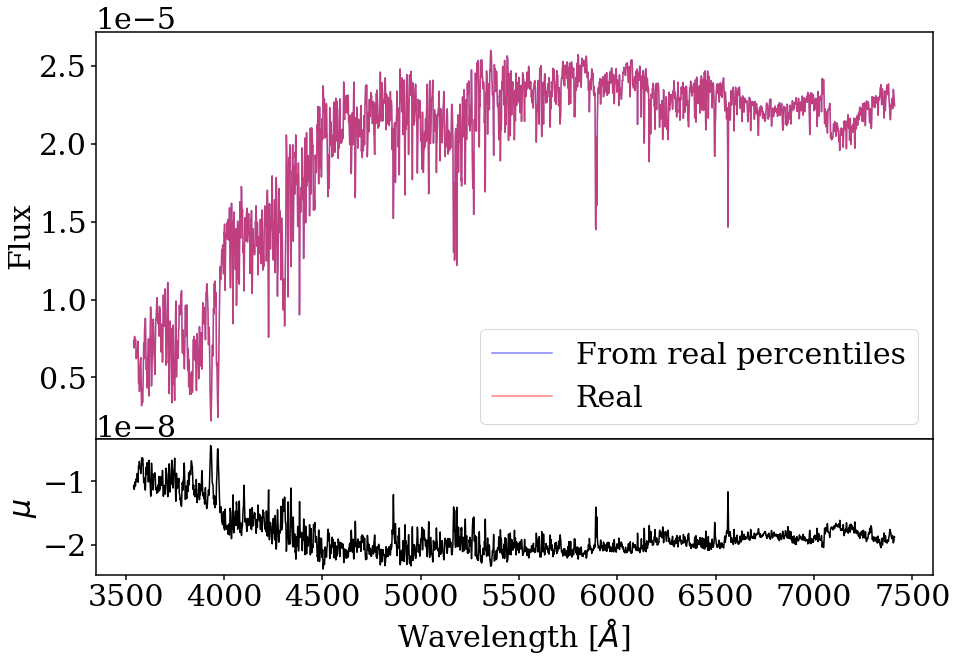

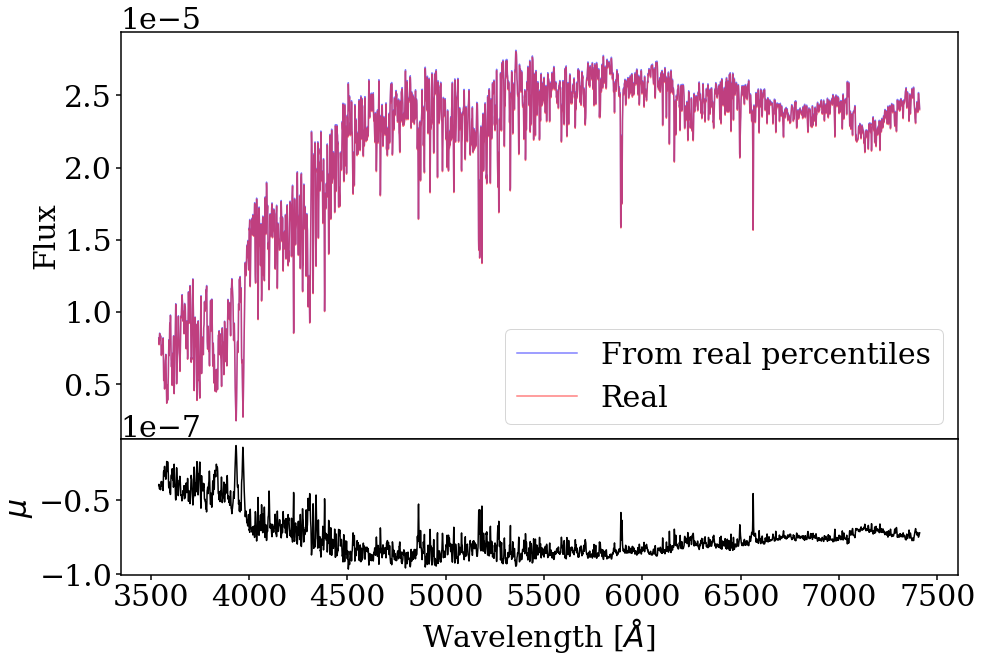

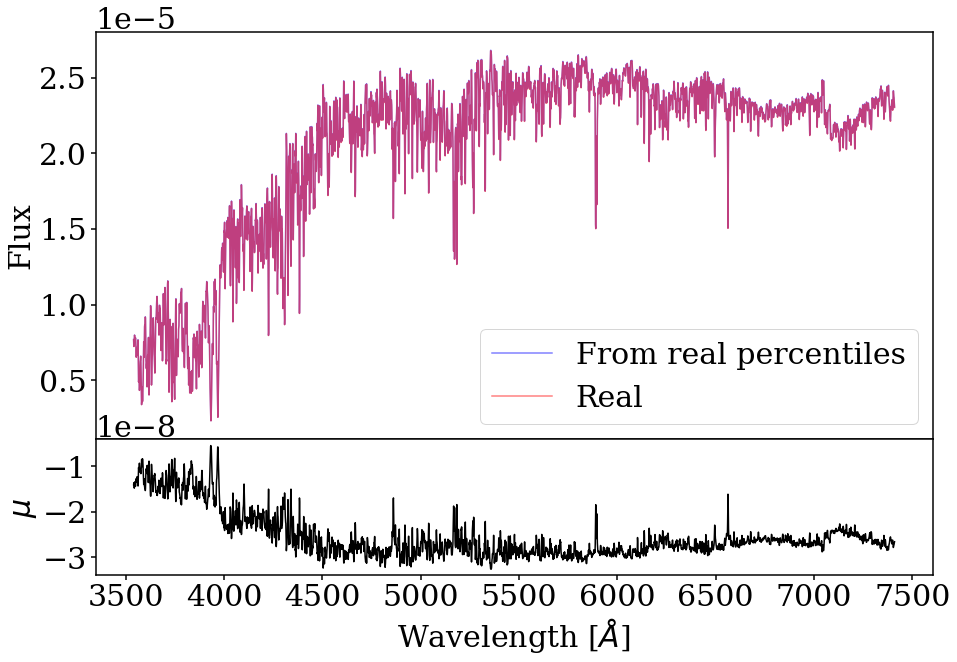

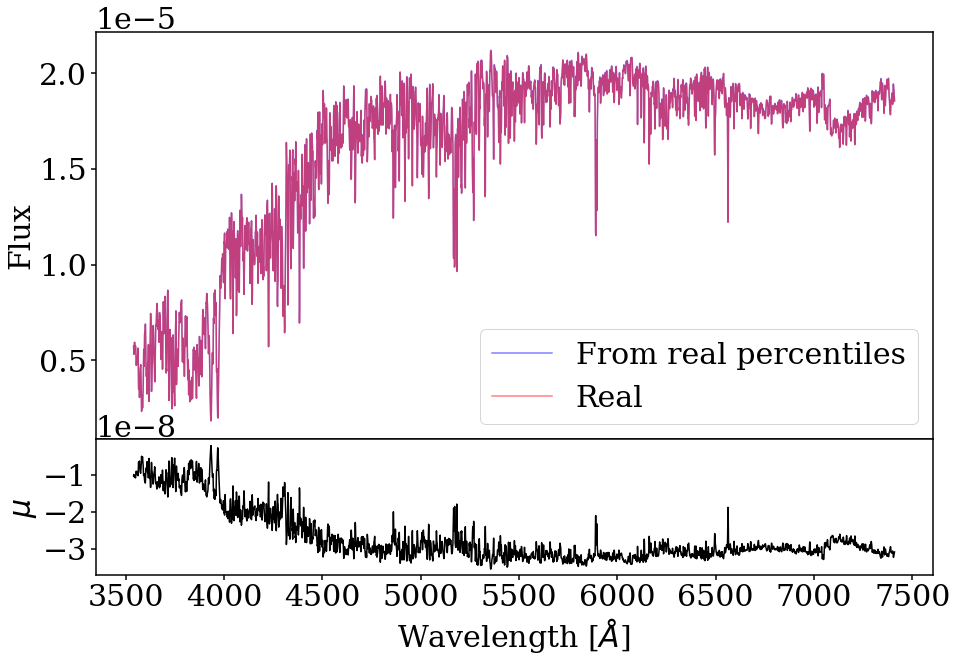

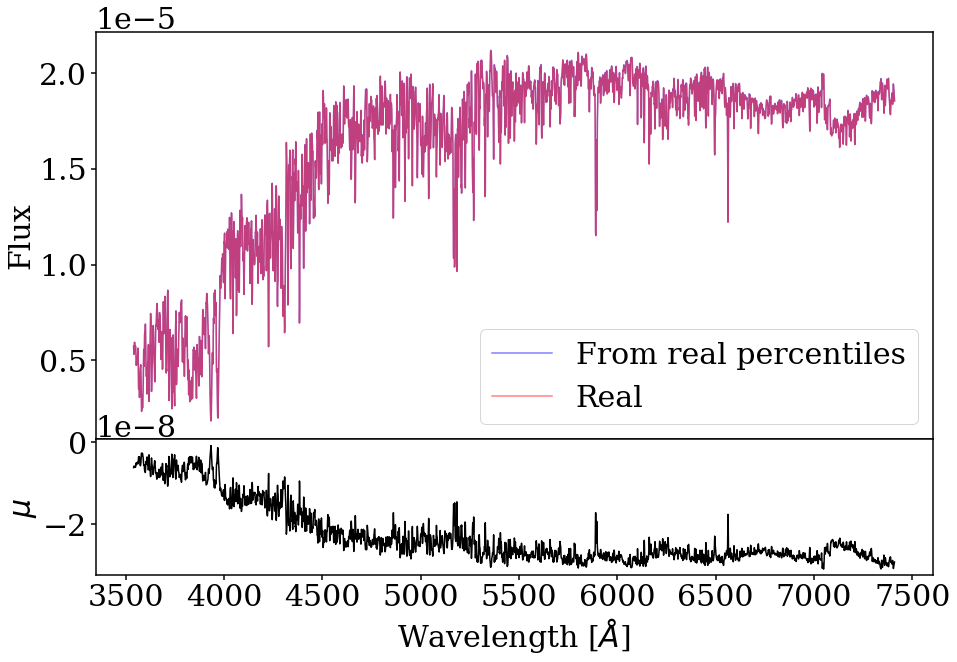

In [10]:
"""for i in np.arange(108):
    plt.plot(wave, seds_from_percentiles[i],'b',label='From percentiles',alpha=0.5)
    plt.plot(wave, seds_real_sh[i],'r',label='Real',alpha=0.5)
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.ylabel('Flux')   
    plt.legend()
    plt.show()"""

for k,i in enumerate(np.random.randint(0,95,5)):
    fig = plt.figure()
    # set height ratios for subplots
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    # the first subplot
    ax0 = plt.subplot(gs[0])
    ax0.plot(wave, seds_from_percentiles[i],'b',label='From real percentiles',alpha=0.5)
    ax0.plot(wave, seds_real_sh[i],'r',label='Real',alpha=0.5)
    #ax0.plot(wave,seds_from_percentiles_pred[i],'b',label='From predicted percentiles',alpha=0.5)
    ax0.set_ylabel('Flux')   
    ax0.legend()
    
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax1.plot(wave,(seds_real_sh[i]-seds_from_percentiles[i]),'k')
    ax1.set_xlabel('Wavelength [$\\AA$]')
    ax1.set_ylabel('$\\mu$')
    
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    if k==0:    
        plt.savefig('./examples/recover_spectra.jpg')
    #plt.savefig('./examples/no_norm'+str(k)+'.jpg')
    plt.show()
    


In [11]:
#now full pipeline for predicted percentiles

#get sfhs

ms_from_percentiles_pred=[]

for k,i in tqdm(enumerate(range(95))):
    per=means_sh[i,:]
    ms=np.gradient(np.arange(0.1,1,0.1),per) * 0.01 #unit msun
    ms_from_percentiles_pred.append(ms)
    

ms_from_percentiles_pred=np.array(ms_from_percentiles_pred)    


#fit to parametric curves to get more data points
params_list=[]
for i in trange(95):
    params, cov = curve_fit(m_linear_exp,percentiles_sh[i,:],ms_from_percentiles[i,:])
    params_list.append(params)

t=np.arange(0,14.01,0.01)

sfhs_from_percentiles_pred=[]

for i in trange(95):
    fit=m_linear_exp(t,params_list[i][0],params_list[i][1],params_list[i][2])
    sfhs_from_percentiles_pred.append(fit/np.sum(fit)) #weights normalized


#generate spectra
wave,data=get_data(dir_name='../../MILES/MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../../MILES/MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
data_extended=interpolate(tbins,t,data)
wave,seds_from_percentiles_pred=generate_all_spectrums(t,sfhs_from_percentiles_pred,wave,data_extended,tbins)



95it [00:00, 10254.49it/s]
  0%|                                                                                                                                                    | 0/95 [00:00<?, ?it/s]/tmp/ipykernel_5552/982757475.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  A=mgal/i[0]
/tmp/ipykernel_5552/982757475.py:53: RuntimeWarning: invalid value encountered in multiply
  return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti)*step #units are Msun
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 354.07it/s]
95it [00:06, 14.63it/s]


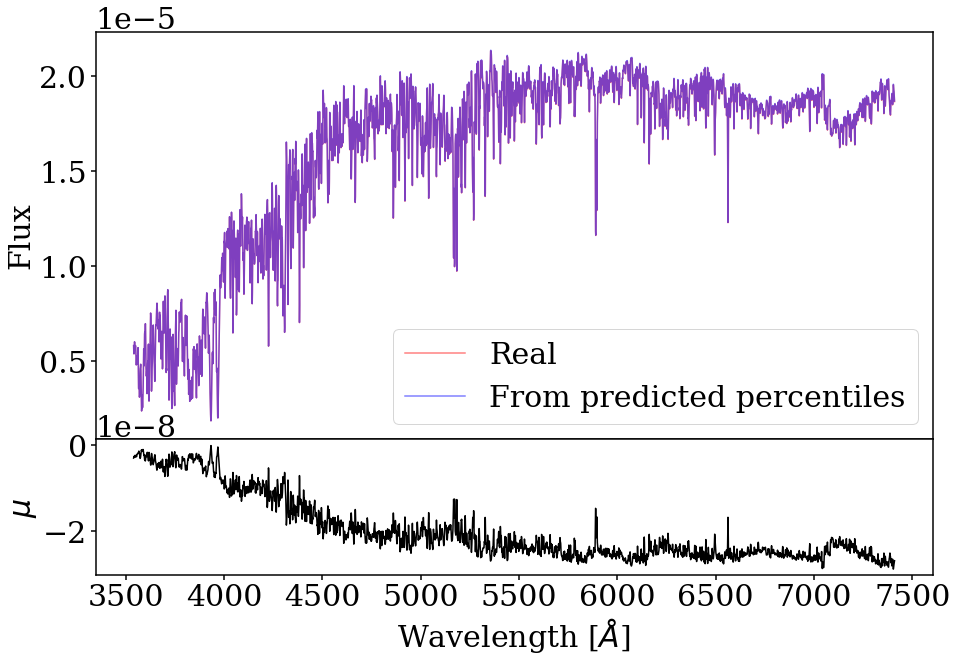

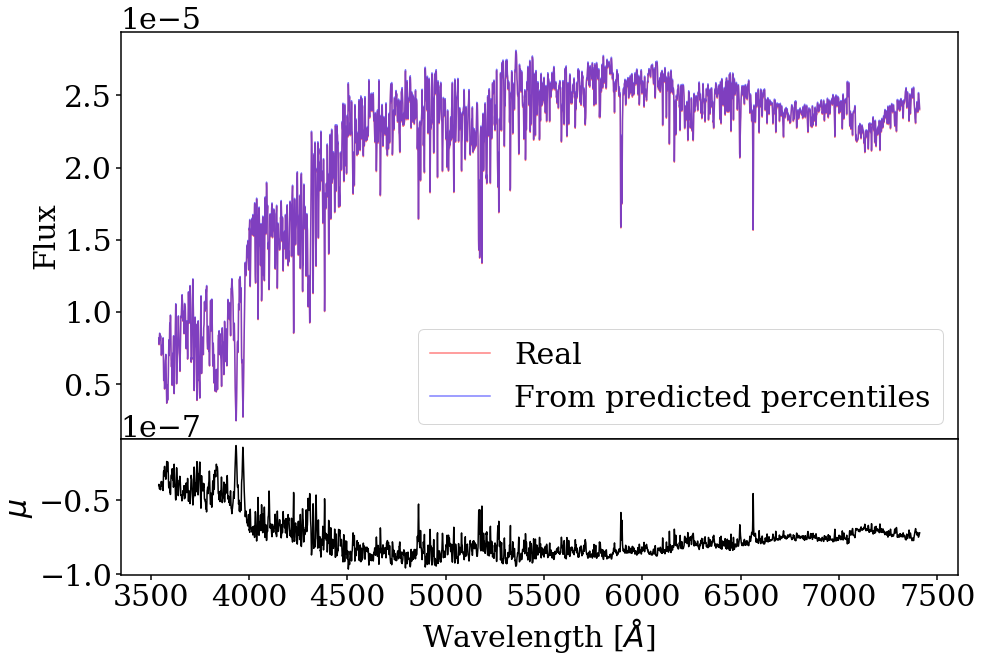

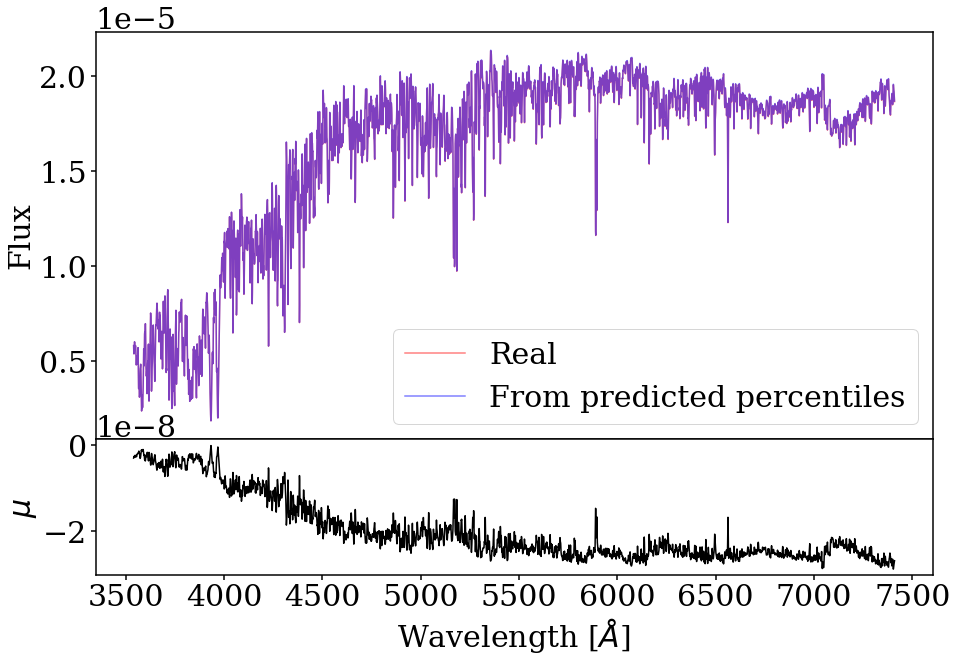

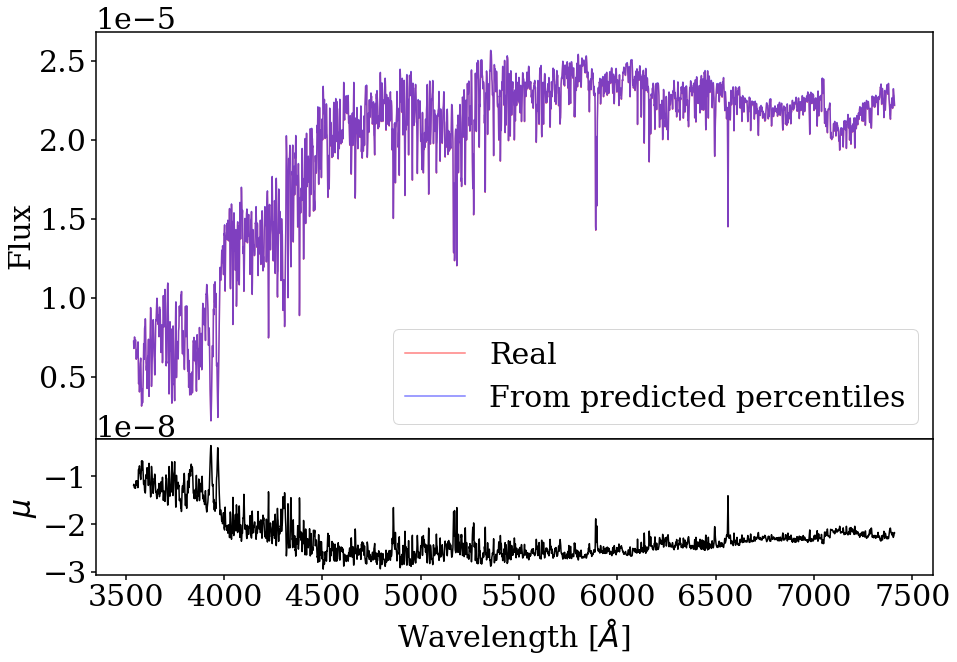

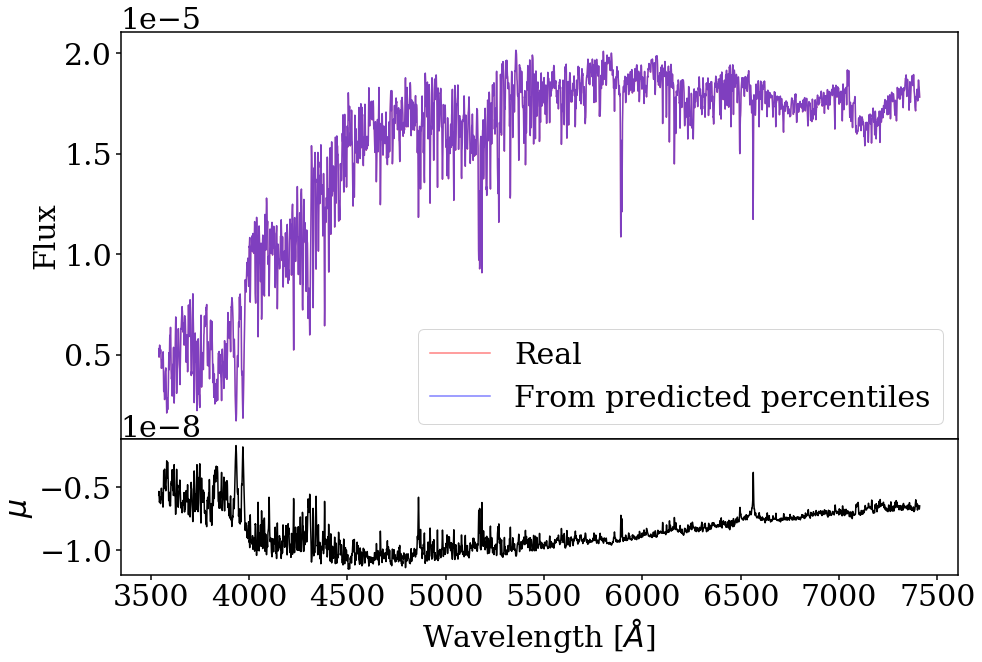

In [12]:
for k,i in enumerate(np.random.randint(0,95,5)):
    fig = plt.figure()
    # set height ratios for subplots
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    # the first subplot
    ax0 = plt.subplot(gs[0])
    #ax0.plot(wave, seds_from_percentiles[i],'b',label='From real percentiles',alpha=0.5)
    ax0.plot(wave, seds_real_sh[i],'r',label='Real',alpha=0.5)
    ax0.plot(wave,seds_from_percentiles_pred[i],'b',label='From predicted percentiles',alpha=0.5)
    ax0.set_ylabel('Flux')   
    ax0.legend()
    
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax1.plot(wave,(seds_real_sh[i]-seds_from_percentiles_pred[i]),'k')
    ax1.set_xlabel('Wavelength [$\\AA$]')
    ax1.set_ylabel('$\\mu$')
    
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    if k==0:
        plt.savefig('./examples/recover_spectra_pred.jpg')
    #plt.savefig('./examples/no_norm'+str(k)+'.jpg')
    plt.show()
   